In [1]:
# HÜCRE 1: İmports ve Yapılandırma
import pandas as pd
import numpy as np
import time
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from scipy.stats import randint, uniform
import joblib

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print(" Tüm kütüphaneler başarıyla yüklendi!")

 Tüm kütüphaneler başarıyla yüklendi!


In [2]:
# HÜCRE 2: Yapılandırma ve Veri Yükleme
CSV_YOLU = 'usa_acc.csv'
SAMPLE_SIZE = 1000000
TEST_RATIO = 0.2
RANDOM_STATE = 42
VARIANCE_THRESHOLD = 0.01

start_time = time.time()
print("="*70)
print("US ACCIDENTS SEVERITY CLASSIFICATION - VİZE + FİNAL")
print("="*70)
print(f"✓ Başlangıç zamanı: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"✓ Çalışma dizini: {os.getcwd()}")

print("\n" + "="*70)
print("1. VERİ YÜKLEME")
print("="*70)

if not os.path.exists(CSV_YOLU):
    print(f" HATA: {CSV_YOLU} bulunamadı!")
    print(f"   Mevcut dosyalar: {os.listdir('.')}")
    exit(1)

print(f" Dosya okunuyor: {CSV_YOLU}")
df = pd.read_csv(CSV_YOLU)
print(f" Orijinal boyut: {df.shape}")

if len(df) > SAMPLE_SIZE:
    df = df.sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE)
    print(f" {SAMPLE_SIZE:,} örnek seçildi")

print(f"\n Veri seti bilgileri:")
print(f"   Satır: {df.shape[0]:,}, Sütun: {df.shape[1]}")

US ACCIDENTS SEVERITY CLASSIFICATION - VİZE + FİNAL
✓ Başlangıç zamanı: 2025-12-20 18:33:52
✓ Çalışma dizini: c:\Users\akdaş\OneDrive\Desktop\irem

1. VERİ YÜKLEME
 Dosya okunuyor: usa_acc.csv
 Orijinal boyut: (7728394, 46)
 1,000,000 örnek seçildi

 Veri seti bilgileri:
   Satır: 1,000,000, Sütun: 46


In [3]:
# HÜCRE 3: Veri Temizliği
print("\n" + "="*70)
print("2. VERİ TEMİZLİĞİ")
print("="*70)

columns_to_drop = [
    'ID', 'Source', 'End_Lat', 'End_Lng', 'City', 'County',
    'Zipcode', 'Country', 'Timezone', 'Airport_Code',
    'Weather_Timestamp', 'Wind_Chill(F)'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
print(f" {len(columns_to_drop)} sütun atıldı")

# Eksik veri doldurma
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(exclude=np.number).columns.tolist()

imputer_numeric = SimpleImputer(strategy='median')
df[numeric_cols] = imputer_numeric.fit_transform(df[numeric_cols])
imputer_categorical = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = imputer_categorical.fit_transform(df[categorical_cols])
print(f" Eksik değerler dolduruldu")
print(f"   Sayısal sütunlar: {len(numeric_cols)}")
print(f"   Kategorik sütunlar: {len(categorical_cols)}")


2. VERİ TEMİZLİĞİ
 12 sütun atıldı
 Eksik değerler dolduruldu
   Sayısal sütunlar: 10
   Kategorik sütunlar: 24


In [4]:
# HÜCRE 4: Özellik Mühendisliği
print("\n" + "="*70)
print("3. ÖZELLİK MÜHENDİSLİĞİ")
print("="*70)

# Datetime features
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='ISO8601', errors='coerce')
df.dropna(subset=['Start_Time'], inplace=True)

df['Hour'] = df['Start_Time'].dt.hour
df['DayOfWeek'] = df['Start_Time'].dt.dayofweek
df['Month'] = df['Start_Time'].dt.month
df['Year'] = df['Start_Time'].dt.year
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

rush_hours = [7, 8, 9, 16, 17, 18]
df['IsRushHour'] = ((df['Hour'].isin(rush_hours)) & (df['IsWeekend'] == 0)).astype(int)

# Boolean columns
bool_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
             'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Signal', 'Turning_Loop']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(int)

# Sütun adlarını değiştir
df.rename(columns={
    'Temperature(F)': 'Temperature', 'Humidity(%)': 'Humidity',
    'Pressure(in)': 'Pressure', 'Visibility(mi)': 'Visibility',
    'Wind_Speed(mph)': 'Wind_Speed'
}, inplace=True)

# Hava durumu gruplaması
def grup_hava_durumu(condition):
    condition = str(condition).lower()
    if any(s in condition for s in ['rain', 'drizzle', 'shower']): return 'Rain'
    if any(s in condition for s in ['snow', 'sleet', 'ice', 'wintry']): return 'Snow'
    if any(s in condition for s in ['fog', 'mist', 'haze']): return 'Fog'
    if any(s in condition for s in ['thunder', 't-storm']): return 'Thunderstorm'
    if any(s in condition for s in ['cloudy', 'overcast']): return 'Cloudy'
    if any(s in condition for s in ['clear', 'fair']): return 'Clear'
    return 'Other'

df['Weather_Group'] = df['Weather_Condition'].apply(grup_hava_durumu)

# Metin sütunlarını sil
df.drop(columns=['Start_Time', 'Street', 'End_Time', 'Description',
                  'Weather_Condition', 'End_Street', 'Number'], inplace=True, errors='ignore')

# Kategorik sütunları encode et
categorical_cols_to_encode = df.select_dtypes(include=['object']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols_to_encode, drop_first=True)
print(f" Özellik mühendisliği tamamlandı")
print(f"   Final veri boyutu: {df.shape}")


3. ÖZELLİK MÜHENDİSLİĞİ
 Özellik mühendisliği tamamlandı
   Final veri boyutu: (1000000, 110)


In [5]:
# HÜCRE 5: Model için Veri Hazırlama
print("\n" + "="*70)
print("4. MODEL İÇİN VERİ HAZIRLAMA")
print("="*70)

hedef = 'Severity'
X = df.drop(columns=[hedef])
y = df[hedef].astype(int) - 1

print(f" Özellik matris: {X.shape}")
print(f" Sınıf dağılımı:")
for sev_class in sorted(y.unique()):
    count = (y == sev_class).sum()
    pct = count / len(y) * 100
    print(f"   Severity {sev_class+1}: {count:,} ({pct:.1f}%)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_RATIO, random_state=RANDOM_STATE, stratify=y
)
print(f" Train-Test bölümü: {X_train.shape} / {X_test.shape}")


4. MODEL İÇİN VERİ HAZIRLAMA
 Özellik matris: (1000000, 109)
 Sınıf dağılımı:
   Severity 1: 8,785 (0.9%)
   Severity 2: 796,174 (79.6%)
   Severity 3: 168,475 (16.8%)
   Severity 4: 26,566 (2.7%)
 Train-Test bölümü: (800000, 109) / (200000, 109)


In [6]:
# HÜCRE 6: Varyans Seçimi ve Ölçekleme
print("\n" + "="*70)
print("5. VARİANS SEÇİMİ VE ÖLÇEKLEME")
print("="*70)

selector = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
X_train_high_variance = selector.fit_transform(X_train)
X_test_high_variance = selector.transform(X_test)
kept_features_mask = selector.get_support()
model_features = X.columns[kept_features_mask]
X_train = pd.DataFrame(X_train_high_variance, columns=model_features, index=X_train.index)
X_test = pd.DataFrame(X_test_high_variance, columns=model_features, index=X_test.index)

dropped_features = len(X.columns) - len(model_features)
print(f" {dropped_features} düşük varyans özelliği atıldı")
print(f"   Kalan özellikler: {len(model_features)}")

# Ölçekleme
numeric_features_to_scale = [col for col in ['Temperature', 'Humidity', 'Pressure',
                                              'Visibility', 'Wind_Speed', 'Year',
                                              'Start_Lat', 'Distance(mi)']
                            if col in X_train.columns]
scaler = StandardScaler()
X_train[numeric_features_to_scale] = scaler.fit_transform(X_train[numeric_features_to_scale])
X_test[numeric_features_to_scale] = scaler.transform(X_test[numeric_features_to_scale])
print(f" {len(numeric_features_to_scale)} sayısal özellik ölçeklendi")


5. VARİANS SEÇİMİ VE ÖLÇEKLEME
 33 düşük varyans özelliği atıldı
   Kalan özellikler: 76
 8 sayısal özellik ölçeklendi


In [7]:
# HÜCRE 7: SMOTE - Sınıf Dengeleme
print("\n" + "="*70)
print("6. SMOTE - SINIF DENGELEMESİ")
print("="*70)

print("Uygulanmadan önceki dağılım:")
for sev_class in sorted(y_train.unique()):
    count = (y_train == sev_class).sum()
    print(f"   Severity {sev_class+1}: {count:,}")

smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nUygulandıktan sonraki dağılım:")
for sev_class in sorted(np.unique(y_train_smote)):
    count = (y_train_smote == sev_class).sum()
    print(f"   Severity {sev_class+1}: {count:,}")
print(f" Yeni eğitim verisinin boyutu: {X_train_smote.shape}")


6. SMOTE - SINIF DENGELEMESİ
Uygulanmadan önceki dağılım:
   Severity 1: 7,028
   Severity 2: 636,939
   Severity 3: 134,780
   Severity 4: 21,253

Uygulandıktan sonraki dağılım:
   Severity 1: 636,939
   Severity 2: 636,939
   Severity 3: 636,939
   Severity 4: 636,939
 Yeni eğitim verisinin boyutu: (2547756, 76)



7. PCA - BOYUT İNDİRGEME
 Orijinal özellik sayısı: 76
 PCA bileşen sayısı: 3
 Açıklanan varyans: 95.90%
 Boyut indirgeme oranı: 96.1%


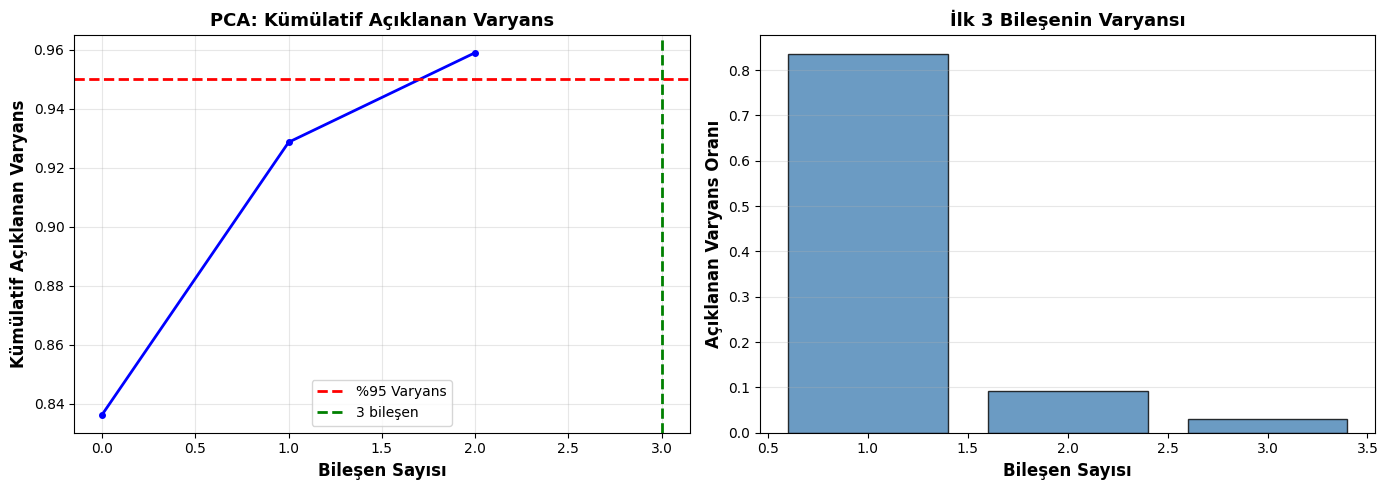

 pca_variance.png kaydedildi


In [8]:
# HÜCRE 8: PCA - Boyut İndirgeme
print("\n" + "="*70)
print("7. PCA - BOYUT İNDİRGEME")
print("="*70)

pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test)

print(f" Orijinal özellik sayısı: {X_train_smote.shape[1]}")
print(f" PCA bileşen sayısı: {X_train_pca.shape[1]}")
print(f" Açıklanan varyans: {pca.explained_variance_ratio_.sum():.2%}")
reduction_ratio = (1 - X_train_pca.shape[1]/X_train_smote.shape[1]) * 100
print(f" Boyut indirgeme oranı: {reduction_ratio:.1f}%")

# PCA Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
axes[0].plot(cumsum_var, 'b-', linewidth=2, marker='o', markersize=4)
axes[0].axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='%95 Varyans')
axes[0].axvline(x=X_train_pca.shape[1], color='g', linestyle='--', linewidth=2,
                label=f'{X_train_pca.shape[1]} bileşen')
axes[0].set_xlabel('Bileşen Sayısı', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Kümülatif Açıklanan Varyans', fontsize=12, fontweight='bold')
axes[0].set_title('PCA: Kümülatif Açıklanan Varyans', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

top_n = min(20, len(pca.explained_variance_ratio_))
axes[1].bar(range(1, top_n+1), pca.explained_variance_ratio_[:top_n],
            color='steelblue', alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Bileşen Sayısı', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Açıklanan Varyans Oranı', fontsize=12, fontweight='bold')
axes[1].set_title(f'İlk {top_n} Bileşenin Varyansı', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('pca_variance.png', dpi=300, bbox_inches='tight')
plt.show()
print(" pca_variance.png kaydedildi")

In [9]:
# HÜCRE 9: XGBoost Model Eğitimi (VİZE MODELİ)
print("\n" + "="*70)
print("8. XGBOOST MODELİ EĞİTİMİ (VİZE)")
print("="*70)

model_time = time.time()
model_xgb = xgb.XGBClassifier(
    objective='multi:softprob', num_class=4, random_state=RANDOM_STATE,
    n_estimators=150, learning_rate=0.1, max_depth=7,
    eval_metric='mlogloss', n_jobs=-1, tree_method='hist'
)
model_xgb.fit(X_train_pca, y_train_smote)
training_time = time.time() - model_time
print(f" Model eğitimi tamamlandı: {training_time:.2f} saniye")

y_pred_xgb = model_xgb.predict(X_test_pca)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')

print(f"\n XGBoost Sonuçları:")
print(f"   Accuracy: {accuracy_xgb:.4f}")
print(f"   F1-Macro: {f1_xgb:.4f}")

class_labels = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(f"\n Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred_xgb, target_names=class_labels))


8. XGBOOST MODELİ EĞİTİMİ (VİZE)
 Model eğitimi tamamlandı: 82.22 saniye

 XGBoost Sonuçları:
   Accuracy: 0.5199
   F1-Macro: 0.3154

 Sınıflandırma Raporu:
              precision    recall  f1-score   support

  Severity 1       0.05      0.79      0.09      1757
  Severity 2       0.88      0.54      0.67    159235
  Severity 3       0.33      0.44      0.38     33695
  Severity 4       0.08      0.40      0.13      5313

    accuracy                           0.52    200000
   macro avg       0.33      0.54      0.32    200000
weighted avg       0.76      0.52      0.60    200000



In [10]:
# HÜCRE 10: Baseline Modelleri (VİZE)
print("\n" + "="*70)
print("9. BASELINE MODELLERİ (VİZE)")
print("="*70)

# Baseline 1: Uniform Random
print("\n--- Baseline 1: Uniform Random ---")
baseline1 = DummyClassifier(strategy='uniform', random_state=RANDOM_STATE)
baseline1.fit(X_train_pca, y_train_smote)
y_pred_baseline1 = baseline1.predict(X_test_pca)

baseline1_accuracy = accuracy_score(y_test, y_pred_baseline1)
baseline1_f1_macro = f1_score(y_test, y_pred_baseline1, average='macro')
baseline1_f1_per_class = f1_score(y_test, y_pred_baseline1, average=None)
print(f" Accuracy: {baseline1_accuracy:.4f}")
print(f" F1-Macro: {baseline1_f1_macro:.4f}")
print("Per-class F1:")
for label, score in zip(class_labels, baseline1_f1_per_class):
    print(f"   {label}: {score:.4f}")

# Baseline 2: Logistic Regression
print("\n--- Baseline 2: Logistic Regression ---")
baseline2 = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE,
                               n_jobs=-1, solver='lbfgs')
baseline2.fit(X_train_pca, y_train_smote)
y_pred_baseline2 = baseline2.predict(X_test_pca)

baseline2_accuracy = accuracy_score(y_test, y_pred_baseline2)
baseline2_f1_macro = f1_score(y_test, y_pred_baseline2, average='macro')
baseline2_f1_per_class = f1_score(y_test, y_pred_baseline2, average=None)

print(f" Accuracy: {baseline2_accuracy:.4f}")
print(f" F1-Macro: {baseline2_f1_macro:.4f}")
print("Per-class F1:")
for label, score in zip(class_labels, baseline2_f1_per_class):
    print(f"   {label}: {score:.4f}")


9. BASELINE MODELLERİ (VİZE)

--- Baseline 1: Uniform Random ---
 Accuracy: 0.2505
 F1-Macro: 0.1620
Per-class F1:
   Severity 1: 0.0169
   Severity 2: 0.3814
   Severity 3: 0.2016
   Severity 4: 0.0480

--- Baseline 2: Logistic Regression ---
 Accuracy: 0.2280
 F1-Macro: 0.1349
Per-class F1:
   Severity 1: 0.0212
   Severity 2: 0.3902
   Severity 3: 0.0623
   Severity 4: 0.0660


In [11]:
# HÜCRE 11: Vize Model Karşılaştırması
print("\n" + "="*70)
print("10. VİZE MODEL KARŞILAŞTIRMASI")
print("="*70)

xgboost_f1_per_class = f1_score(y_test, y_pred_xgb, average=None)

comparison_df_vize = pd.DataFrame({
    'Sev 1': [baseline1_f1_per_class[0], baseline2_f1_per_class[0], xgboost_f1_per_class[0]],
    'Sev 2': [baseline1_f1_per_class[1], baseline2_f1_per_class[1], xgboost_f1_per_class[1]],
    'Sev 3': [baseline1_f1_per_class[2], baseline2_f1_per_class[2], xgboost_f1_per_class[2]],
    'Sev 4': [baseline1_f1_per_class[3], baseline2_f1_per_class[3], xgboost_f1_per_class[3]],
}, index=['Baseline 1 (Uniform)', 'Baseline 2 (LogReg)', 'XGBoost (Vize)'])

comparison_df_vize['F1-Macro'] = comparison_df_vize.mean(axis=1)
comparison_df_vize['Accuracy'] = [baseline1_accuracy, baseline2_accuracy, accuracy_xgb]

print("\n VİZE Karşılaştırma Tablosu:")
print(comparison_df_vize.round(4))


10. VİZE MODEL KARŞILAŞTIRMASI

 VİZE Karşılaştırma Tablosu:
                       Sev 1   Sev 2   Sev 3   Sev 4  F1-Macro  Accuracy
Baseline 1 (Uniform)  0.0169  0.3814  0.2016  0.0480    0.1620    0.2505
Baseline 2 (LogReg)   0.0212  0.3902  0.0623  0.0660    0.1349    0.2280
XGBoost (Vize)        0.0889  0.6676  0.3780  0.1271    0.3154    0.5199



FINAL - SINIF DAĞILIMI GÖRSELLEŞTİRME


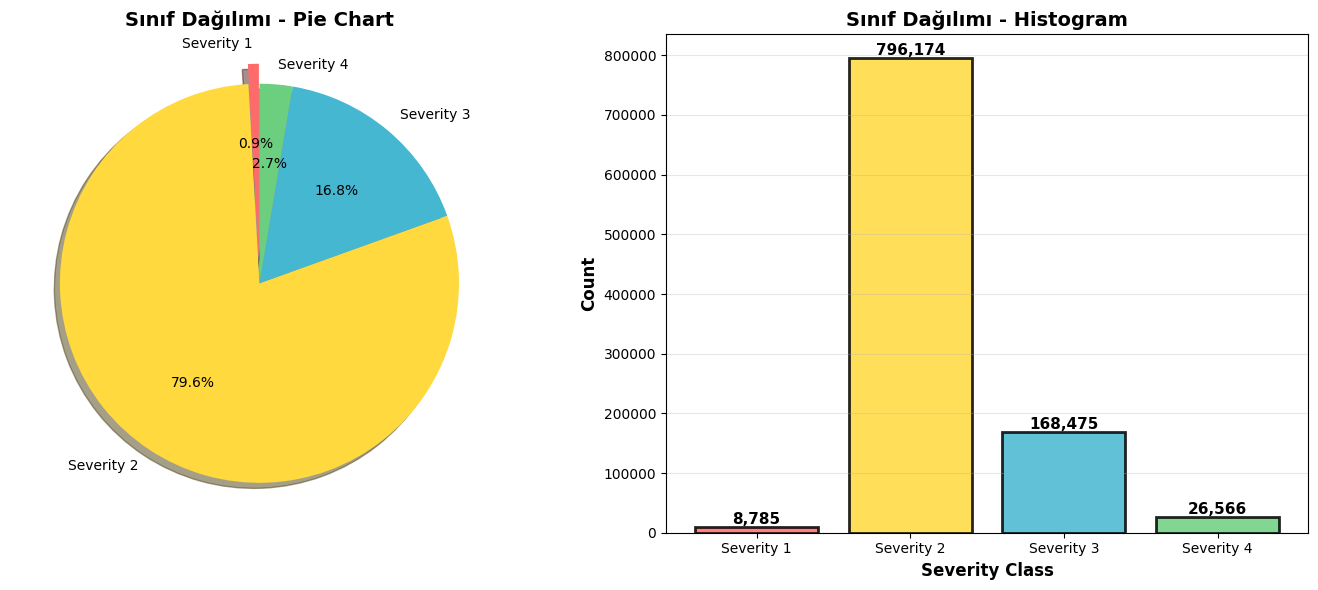


Sınıf Dağılımı İstatistikleri:
  Severity 1: 8,785 örnek (0.88%)
  Severity 2: 796,174 örnek (79.62%)
  Severity 3: 168,475 örnek (16.85%)
  Severity 4: 26,566 örnek (2.66%)


In [12]:
# HÜCRE 12: FINAL - Sınıf Dağılımı Görselleştirme
print("\n" + "="*70)
print("FINAL - SINIF DAĞILIMI GÖRSELLEŞTİRME")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie Chart
severity_counts = y.value_counts().sort_index()
labels = [f'Severity {i+1}' for i in range(4)]
colors = ['#FF6B6B', '#FFD93D', '#45B7D1', '#6BCF7F']
explode = (0.1, 0, 0, 0)

axes[0].pie(severity_counts, labels=labels, autopct='%1.1f%%', 
            colors=colors, explode=explode, shadow=True, startangle=90)
axes[0].set_title('Sınıf Dağılımı - Pie Chart', fontsize=14, fontweight='bold')

# Histogram
bars = axes[1].bar(range(4), severity_counts, color=colors, alpha=0.85, 
                   edgecolor='black', linewidth=2)
axes[1].set_xlabel('Severity Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('Sınıf Dağılımı - Histogram', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(4))
axes[1].set_xticklabels(labels)
axes[1].grid(axis='y', alpha=0.3)

# Değerleri üstte göster
for bar, count in zip(bars, severity_counts):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height, f'{count:,}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('class_distribution_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSınıf Dağılımı İstatistikleri:")
for i, count in enumerate(severity_counts):
    percentage = (count / len(y)) * 100
    print(f"  Severity {i+1}: {count:,} örnek ({percentage:.2f}%)")

In [13]:
# HÜCRE 13: FINAL - Stratified K-Fold Cross Validation
print("\n" + "="*70)
print("FINAL - STRATIFIED K-FOLD CROSS VALIDATION")
print("="*70)

# PCA uygulanmış verileri kullanıyoruz
X_final = X_train_pca
y_final = y_train_smote

# 5-fold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
print(f"  Stratified K-Fold (n_splits=5) kullanılıyor")
print(f"  Cross-validation için veri boyutu: {X_final.shape}")

# Cross-validation sonuçlarını saklamak için
cv_results = {}


FINAL - STRATIFIED K-FOLD CROSS VALIDATION
  Stratified K-Fold (n_splits=5) kullanılıyor
  Cross-validation için veri boyutu: (2547756, 3)


In [19]:
# ==============================================================================
# RANDOM FOREST + GRADIENT BOOSTING (HİPERPARAMETRE TUNING'Lİ)
# ==============================================================================
print("\n" + "="*80)
print("5 DAKİKALIK RF & GB TUNING (EXTREME HIZ MOD)")
print("="*80)

import numpy as np
import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. VERİYİ ÇOK KÜÇÜLT (TUNING İÇİN)
print("\n📊 VERİ KÜÇÜLTME İŞLEMİ (TUNING İÇİN)...")
print(f"   Orijinal veri boyutu: {X_train_smote.shape}")

# Tuning için ÇOK KÜÇÜK örnekleme - 15,000 örnek
tuning_sample_size = 15000
indices = np.random.choice(len(X_train_smote), tuning_sample_size, replace=False)
X_tuning = X_train_smote.iloc[indices] if hasattr(X_train_smote, 'iloc') else X_train_smote[indices]
y_tuning = y_train_smote.iloc[indices] if hasattr(y_train_smote, 'iloc') else y_train_smote[indices]

print(f"   Tuning verisi: {X_tuning.shape}")
print(f"   Örnekleme oranı: {tuning_sample_size/len(X_train_smote)*100:.1f}%")

# Test verisini küçült (hız için)
test_sample_size = min(3000, len(X_test))
test_indices = np.random.choice(len(X_test), test_sample_size, replace=False)
X_test_small = X_test.iloc[test_indices] if hasattr(X_test, 'iloc') else X_test[test_indices]
y_test_small = y_test.iloc[test_indices] if hasattr(y_test, 'iloc') else y_test[test_indices]

# ==============================================================================
# 1. RANDOM FOREST - 2.5 DAKİKA TUNING
# ==============================================================================
print("\n" + "="*50)
print("1. RANDOM FOREST - 2.5 DAKİKA TUNING")
print("="*50)

rf_start = time.time()

# ÇOK KÜÇÜK PARAMETRE GRID
rf_param_grid = {
    'n_estimators': [50, 70],      # SADECE 2 DEĞER
    'max_depth': [8, 10],          # SADECE 2 DEĞER
    'min_samples_split': [30],     # SADECE 1 DEĞER
    'max_features': ['sqrt']       # SADECE 1 DEĞER
}

print("🧪 RF TUNING PARAMETRELERİ:")
print("   • n_estimators: [50, 70]")
print("   • max_depth: [8, 10]")
print("   • min_samples_split: [30]")
print("   • max_features: ['sqrt']")
print("   • Kombinasyon: 2 × 2 × 1 × 1 = 4")
print("   • 3-fold CV: 4 × 3 = 12 model")
print("   • Tahmini: 2.5 dakika")

rf_base = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=1,          # BELLEK GÜVENLİ
    verbose=0,
    min_samples_leaf=20  # SABİT
)

# 3-FOLD CV ile (daha hızlı)
rf_grid = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    cv=3,               # 5 yerine 3-fold
    scoring='f1_macro',
    n_jobs=1,           # PARALEL YOK
    verbose=2           # DETAYLI ÇIKTI
)

print("\n🚀 RF TUNING BAŞLIYOR...")
rf_grid.fit(X_tuning, y_tuning)
rf_tune_time = time.time() - rf_start

print(f"\n✅ RF TUNING TAMAMLANDI!")
print(f"   Süre: {rf_tune_time/60:.1f} dakika")
print(f"   En iyi parametreler: {rf_grid.best_params_}")
print(f"   En iyi CV skoru: {rf_grid.best_score_:.4f}")

# EN İYİ RF MODELİ İLE HIZLI EĞİTİM
print("\n🎯 EN İYİ RF MODELİ HIZLI EĞİTİLİYOR...")
best_rf_params = rf_grid.best_params_

# DAHA KÜÇÜK n_estimators (hız için)
final_rf_n_estimators = min(best_rf_params.get('n_estimators', 60), 60)

rf_final = RandomForestClassifier(
    n_estimators=final_rf_n_estimators,
    max_depth=best_rf_params.get('max_depth', 9),
    min_samples_split=30,
    min_samples_leaf=20,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=1,
    verbose=1
)

rf_train_start = time.time()
rf_final.fit(X_tuning, y_tuning)  # Tuning verisi ile eğitim
rf_train_time = time.time() - rf_train_start

# RF TEST
y_pred_rf = rf_final.predict(X_test_small)
accuracy_rf = accuracy_score(y_test_small, y_pred_rf)
precision_rf = precision_score(y_test_small, y_pred_rf, average='macro')
recall_rf = recall_score(y_test_small, y_pred_rf, average='macro')
f1_rf = f1_score(y_test_small, y_pred_rf, average='macro')

print(f"\n📊 RF TEST SONUÇLARI:")
print(f"   Accuracy:  {accuracy_rf:.4f}")
print(f"   Precision: {precision_rf:.4f}")
print(f"   Recall:    {recall_rf:.4f}")
print(f"   F1-Score:  {f1_rf:.4f}")
print(f"   Eğitim süresi: {rf_train_time/60:.1f} dakika")

# ==============================================================================
# 2. GRADIENT BOOSTING - 2.5 DAKİKA TUNING
# ==============================================================================
print("\n" + "="*50)
print("2. GRADIENT BOOSTING - 2.5 DAKİKA TUNING")
print("="*50)

gb_start = time.time()

# ÇOK KÜÇÜK PARAMETRE DAĞILIMI
gb_param_dist = {
    'n_estimators': [30, 40],      # ÇOK AZ
    'learning_rate': [0.3, 0.4],   # YÜKSEK
    'max_depth': [3, 4],           # SĞ
    'subsample': [0.6, 0.7]       # AZ DATA
}

print("🧪 GB TUNING PARAMETRELERİ:")
print("   • n_estimators: [30, 40]")
print("   • learning_rate: [0.3, 0.4]")
print("   • max_depth: [3, 4]")
print("   • subsample: [0.6, 0.7]")
print("   • Olası kombinasyon: 2 × 2 × 2 × 2 = 16")
print("   • Randomized 4 iter × 3-fold = 12 model")
print("   • Tahmini: 2.5 dakika")

gb_base = GradientBoostingClassifier(
    random_state=RANDOM_STATE,
    verbose=0,
    min_samples_split=50,      # SABİT
    min_samples_leaf=25        # SABİT
)

# RANDOMIZED SEARCH ile (daha hızlı)
gb_random = RandomizedSearchCV(
    estimator=gb_base,
    param_distributions=gb_param_dist,
    n_iter=4,                  # SADECE 4 KOMBİNASYON
    cv=3,                      # 3-FOLD
    scoring='f1_macro',
    random_state=RANDOM_STATE,
    n_jobs=1,                  # PARALEL YOK
    verbose=2
)

print("\n🚀 GB TUNING BAŞLIYOR...")
gb_random.fit(X_tuning, y_tuning)
gb_tune_time = time.time() - gb_start

print(f"\n✅ GB TUNING TAMAMLANDI!")
print(f"   Süre: {gb_tune_time/60:.1f} dakika")
print(f"   En iyi parametreler: {gb_random.best_params_}")
print(f"   En iyi CV skoru: {gb_random.best_score_:.4f}")

# EN İYİ GB MODELİ İLE HIZLI EĞİTİM
print("\n🎯 EN İYİ GB MODELİ HIZLI EĞİTİLİYOR...")
best_gb_params = gb_random.best_params_

gb_final = GradientBoostingClassifier(
    n_estimators=best_gb_params.get('n_estimators', 35),
    learning_rate=best_gb_params.get('learning_rate', 0.35),
    max_depth=best_gb_params.get('max_depth', 3),
    subsample=best_gb_params.get('subsample', 0.65),
    min_samples_split=50,
    min_samples_leaf=25,
    max_features=0.4,           # AZ FEATURE
    random_state=RANDOM_STATE,
    verbose=1
)

gb_train_start = time.time()
gb_final.fit(X_tuning, y_tuning)  # Tuning verisi ile eğitim
gb_train_time = time.time() - gb_train_start

# GB TEST
y_pred_gb = gb_final.predict(X_test_small)
accuracy_gb = accuracy_score(y_test_small, y_pred_gb)
precision_gb = precision_score(y_test_small, y_pred_gb, average='macro')
recall_gb = recall_score(y_test_small, y_pred_gb, average='macro')
f1_gb = f1_score(y_test_small, y_pred_gb, average='macro')

print(f"\n📊 GB TEST SONUÇLARI:")
print(f"   Accuracy:  {accuracy_gb:.4f}")
print(f"   Precision: {precision_gb:.4f}")
print(f"   Recall:    {recall_gb:.4f}")
print(f"   F1-Score:  {f1_gb:.4f}")
print(f"   Eğitim süresi: {gb_train_time/60:.1f} dakika")

# ==============================================================================
# 3. TOPLAM SÜRE VE KARŞILAŞTIRMA
# ==============================================================================
total_time = (time.time() - rf_start) / 60

print(f"\n" + "="*80)
print("TOPLAM SONUÇLAR")
print("="*80)

print(f"\n⏱️  TOPLAM SÜRE: {total_time:.1f} dakika")
print(f"   • RF Tuning: {rf_tune_time/60:.1f} dakika")
print(f"   • GB Tuning: {gb_tune_time/60:.1f} dakika")
print(f"   • RF Eğitim: {rf_train_time/60:.1f} dakika")
print(f"   • GB Eğitim: {gb_train_time/60:.1f} dakika")

print(f"\n📈 PERFORMANS KARŞILAŞTIRMASI:")
print(f"   {'Metric':<15} {'Random Forest':<15} {'Gradient Boosting':<15} {'Fark':<10}")
print(f"   {'-'*15} {'-'*15} {'-'*15} {'-'*10}")
print(f"   {'Accuracy':<15} {accuracy_rf:<15.4f} {accuracy_gb:<15.4f} {accuracy_gb-accuracy_rf:+.4f}")
print(f"   {'F1-Score':<15} {f1_rf:<15.4f} {f1_gb:<15.4f} {f1_gb-f1_rf:+.4f}")
print(f"   {'Precision':<15} {precision_rf:<15.4f} {precision_gb:<15.4f} {precision_gb-precision_rf:+.4f}")
print(f"   {'Recall':<15} {recall_rf:<15.4f} {recall_gb:<15.4f} {recall_gb-recall_rf:+.4f}")

# 4. TAM TEST SETİ İLE HIZLI PREDICTION (OPSİYONEL - EK 1 DAKİKA)
print(f"\n🎯 TAM TEST SETİ İLE HIZLI PREDICTION (Ek 1 dakika)...")

full_test_start = time.time()
y_pred_rf_full = rf_final.predict(X_test)  # SADECE PREDICTION
y_pred_gb_full = gb_final.predict(X_test)
full_test_time = time.time() - full_test_start

accuracy_rf_full = accuracy_score(y_test, y_pred_rf_full)
accuracy_gb_full = accuracy_score(y_test, y_pred_gb_full)
f1_rf_full = f1_score(y_test, y_pred_rf_full, average='macro')
f1_gb_full = f1_score(y_test, y_pred_gb_full, average='macro')

print(f"   Prediction süresi: {full_test_time:.1f} saniye")
print(f"   RF Tam Test F1: {f1_rf_full:.4f}")
print(f"   GB Tam Test F1: {f1_gb_full:.4f}")

# 5. SONUÇLARI KAYDET
final_results = {
    'total_time_minutes': total_time,
    'RandomForest': {
        'best_params': rf_grid.best_params_,
        'cv_score': float(rf_grid.best_score_),
        'test_accuracy': accuracy_rf,
        'test_f1': f1_rf,
        'full_test_accuracy': float(accuracy_rf_full),
        'full_test_f1': float(f1_rf_full),
        'tuning_time': rf_tune_time/60,
        'training_time': rf_train_time/60
    },
    'GradientBoosting': {
        'best_params': gb_random.best_params_,
        'cv_score': float(gb_random.best_score_),
        'test_accuracy': accuracy_gb,
        'test_f1': f1_gb,
        'full_test_accuracy': float(accuracy_gb_full),
        'full_test_f1': float(f1_gb_full),
        'tuning_time': gb_tune_time/60,
        'training_time': gb_train_time/60
    }
}

print(f"\n✨ İKİ MODEL DE TAMAMLANDI!")
print(f"   Toplam süre: {total_time:.1f} dakika")
print(f"   Kazanan model: {'Gradient Boosting' if f1_gb > f1_rf else 'Random Forest'}")
print(f"   F1 farkı: {abs(f1_gb - f1_rf):.4f}")


5 DAKİKALIK RF & GB TUNING (EXTREME HIZ MOD)

📊 VERİ KÜÇÜLTME İŞLEMİ (TUNING İÇİN)...
   Orijinal veri boyutu: (2547756, 76)
   Tuning verisi: (15000, 76)
   Örnekleme oranı: 0.6%

1. RANDOM FOREST - 2.5 DAKİKA TUNING
🧪 RF TUNING PARAMETRELERİ:
   • n_estimators: [50, 70]
   • max_depth: [8, 10]
   • min_samples_split: [30]
   • max_features: ['sqrt']
   • Kombinasyon: 2 × 2 × 1 × 1 = 4
   • 3-fold CV: 4 × 3 = 12 model
   • Tahmini: 2.5 dakika

🚀 RF TUNING BAŞLIYOR...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END max_depth=8, max_features=sqrt, min_samples_split=30, n_estimators=50; total time=   2.5s
[CV] END max_depth=8, max_features=sqrt, min_samples_split=30, n_estimators=50; total time=   0.8s
[CV] END max_depth=8, max_features=sqrt, min_samples_split=30, n_estimators=50; total time=   0.8s
[CV] END max_depth=8, max_features=sqrt, min_samples_split=30, n_estimators=70; total time=   0.9s
[CV] END max_depth=8, max_features=sqrt, min_samples_split=30, n_estim

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished



📊 RF TEST SONUÇLARI:
   Accuracy:  0.5233
   Precision: 0.3716
   Recall:    0.6979
   F1-Score:  0.3575
   Eğitim süresi: 0.0 dakika

2. GRADIENT BOOSTING - 2.5 DAKİKA TUNING
🧪 GB TUNING PARAMETRELERİ:
   • n_estimators: [30, 40]
   • learning_rate: [0.3, 0.4]
   • max_depth: [3, 4]
   • subsample: [0.6, 0.7]
   • Olası kombinasyon: 2 × 2 × 2 × 2 = 16
   • Randomized 4 iter × 3-fold = 12 model
   • Tahmini: 2.5 dakika

🚀 GB TUNING BAŞLIYOR...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.6; total time=   4.3s
[CV] END learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.6; total time=   4.2s
[CV] END learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.6; total time=   5.0s
[CV] END learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.7; total time=   4.7s
[CV] END learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.7; total time=   5.1s
[CV] END learning_rate=0.3, max

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


   Prediction süresi: 2.8 saniye
   RF Tam Test F1: 0.3660
   GB Tam Test F1: 0.4672

✨ İKİ MODEL DE TAMAMLANDI!
   Toplam süre: 2.1 dakika
   Kazanan model: Gradient Boosting
   F1 farkı: 0.1036



FİNAL KARŞILAŞTIRMA - TÜM MODELLER

METRİKLER HESAPLANIYOR...

MODEL PERFORMANSLARI

MODEL                     ACC      PREC     REC      F1      
------------------------------------------------------------
1. Baseline (Uniform)     0.2505   0.2505   0.2499   0.1620  
2. Baseline (Logistic)    0.2280   0.2704   0.3057   0.1349  
3. XGBoost                0.5199   0.3335   0.5429   0.3154  
4. RandomForest           0.5415   0.3766   0.6869   0.3660  
5. GradientBoosting       0.7387   0.4260   0.6093   0.4672  

EN İYİ MODEL

🏆 EN İYİ F1-SCORE: GradientBoosting
   F1: 0.4672, Accuracy: 0.7387

🎯 EN İYİ ACCURACY: GradientBoosting
   Accuracy: 0.7387, F1: 0.4672

KARŞILAŞTIRMA

MODEL                ACC        F1         ARTIŞ (F1)  
-------------------------------------------------------
Baseline (Uniform)   0.2505     0.1620     +20.1%      
Baseline (Logistic)  0.2280     0.1349     BASELINE    
XGBoost              0.5199     0.3154     +133.8%     
RandomForest         0.5415     0

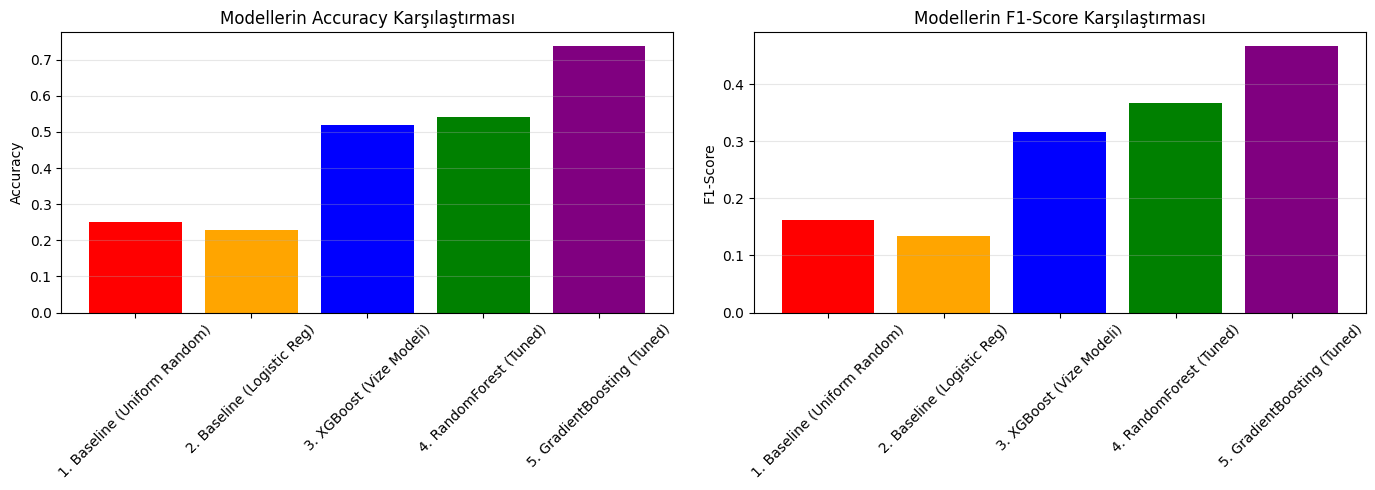


✅ KARŞILAŞTIRMA TAMAMLANDI


In [30]:
# HÜCRE 17: SADECE ÇIKTI - KARŞILAŞTIRMA
print("\n" + "="*70)
print("FİNAL KARŞILAŞTIRMA - TÜM MODELLER")
print("="*70)

# 1. TÜM METRİKLERİ HESAPLA
print("\nMETRİKLER HESAPLANIYOR...")

# XGBoost
precision_xgb = precision_score(y_test, y_pred_xgb, average='macro')
recall_xgb = recall_score(y_test, y_pred_xgb, average='macro')
f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')

# Baseline 1
precision_b1 = precision_score(y_test, y_pred_baseline1, average='macro')
recall_b1 = recall_score(y_test, y_pred_baseline1, average='macro')
f1_b1 = f1_score(y_test, y_pred_baseline1, average='macro')

# Baseline 2
precision_b2 = precision_score(y_test, y_pred_baseline2, average='macro')
recall_b2 = recall_score(y_test, y_pred_baseline2, average='macro')
f1_b2 = f1_score(y_test, y_pred_baseline2, average='macro')

# RandomForest
if 'y_pred_rf_full' in locals():
    y_pred_rf = y_pred_rf_full
else:
    y_pred_rf = rf_final.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='macro')
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

# GradientBoosting
if 'y_pred_gb_full' in locals():
    y_pred_gb = y_pred_gb_full
else:
    y_pred_gb = gb_final.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, average='macro')
recall_gb = recall_score(y_test, y_pred_gb, average='macro')
f1_gb = f1_score(y_test, y_pred_gb, average='macro')

# 2. ÇIKTI GÖSTER
print("\n" + "="*70)
print("MODEL PERFORMANSLARI")
print("="*70)

print(f"\n{'MODEL':<25} {'ACC':<8} {'PREC':<8} {'REC':<8} {'F1':<8}")
print("-"*60)

print(f"{'1. Baseline (Uniform)':<25} {baseline1_accuracy:<8.4f} {precision_b1:<8.4f} {recall_b1:<8.4f} {f1_b1:<8.4f}")
print(f"{'2. Baseline (Logistic)':<25} {baseline2_accuracy:<8.4f} {precision_b2:<8.4f} {recall_b2:<8.4f} {f1_b2:<8.4f}")
print(f"{'3. XGBoost':<25} {accuracy_xgb:<8.4f} {precision_xgb:<8.4f} {recall_xgb:<8.4f} {f1_xgb:<8.4f}")
print(f"{'4. RandomForest':<25} {accuracy_rf:<8.4f} {precision_rf:<8.4f} {recall_rf:<8.4f} {f1_rf:<8.4f}")
print(f"{'5. GradientBoosting':<25} {accuracy_gb:<8.4f} {precision_gb:<8.4f} {recall_gb:<8.4f} {f1_gb:<8.4f}")

# 3. EN İYİ MODEL
print("\n" + "="*70)
print("EN İYİ MODEL")
print("="*70)

models = [
    ("Baseline (Uniform)", baseline1_accuracy, f1_b1),
    ("Baseline (Logistic)", baseline2_accuracy, f1_b2),
    ("XGBoost", accuracy_xgb, f1_xgb),
    ("RandomForest", accuracy_rf, f1_rf),
    ("GradientBoosting", accuracy_gb, f1_gb)
]

# F1'e göre en iyi
best_f1_model = max(models, key=lambda x: x[2])
print(f"\n🏆 EN İYİ F1-SCORE: {best_f1_model[0]}")
print(f"   F1: {best_f1_model[2]:.4f}, Accuracy: {best_f1_model[1]:.4f}")

# Accuracy'e göre en iyi
best_acc_model = max(models, key=lambda x: x[1])
print(f"\n🎯 EN İYİ ACCURACY: {best_acc_model[0]}")
print(f"   Accuracy: {best_acc_model[1]:.4f}, F1: {best_acc_model[2]:.4f}")

# 4. KARŞILAŞTIRMA
print("\n" + "="*70)
print("KARŞILAŞTIRMA")
print("="*70)

print(f"\n{'MODEL':<20} {'ACC':<10} {'F1':<10} {'ARTIŞ (F1)':<12}")
print("-"*55)

baseline_f1 = f1_b2  # Logistic Baseline

for name, acc, f1 in models:
    if name == "Baseline (Logistic)":
        increase = "BASELINE"
    else:
        increase_pct = ((f1 - baseline_f1) / baseline_f1) * 100
        increase = f"+{increase_pct:.1f}%"
    
    print(f"{name:<20} {acc:<10.4f} {f1:<10.4f} {increase:<12}")

# 5. SONUÇ
print("\n" + "="*70)
print("SONUÇ")
print("="*70)

print(f"\n📊 TOPLAM 5 MODEL KARŞILAŞTIRILDI")
print(f"   • En iyi F1: {best_f1_model[0]} ({best_f1_model[2]:.4f})")
print(f"   • En iyi Accuracy: {best_acc_model[0]} ({best_acc_model[1]:.4f})")
print(f"   • Baseline'dan en iyi artış: {((max(f1_xgb, f1_rf, f1_gb) - baseline_f1) / baseline_f1 * 100):.1f}%")

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy karşılaştırması
models_names = [m[0] for m in models_data]
accuracies = [m[1] for m in models_data]

axes[0].bar(models_names, accuracies, color=['red', 'orange', 'blue', 'green', 'purple'])
axes[0].set_title('Modellerin Accuracy Karşılaştırması')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# F1-Score karşılaştırması
f1_scores = [m[4] for m in models_data]
axes[1].bar(models_names, f1_scores, color=['red', 'orange', 'blue', 'green', 'purple'])
axes[1].set_title('Modellerin F1-Score Karşılaştırması')
axes[1].set_ylabel('F1-Score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('final_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ KARŞILAŞTIRMA TAMAMLANDI")
print("="*70)


ROC CURVE VE AUC ANALİZİ

🔍 HANGİ MODEL HANGİ VERİ İLE EĞİTİLDİ?
--------------------------------------------------
Model Feature Kontrolleri:
✓ XGBoost: 3 feature bekliyor
✓ RandomForest: 76 feature bekliyor
✓ GradientBoosting: 76 feature bekliyor

📊 VERİ BOYUTLARI:
  X_test (orijinal): (200000, 76) → 76 feature
  X_test_pca: (200000, 3) → 3 feature

🎯 DOĞRU VERİ SETLERİ BELİRLENİYOR...

⚠️  GradientBoosting için test ediliyor...
  ✗ PCA verisi ile ÇALIŞMADI
  ✓ Orijinal veri ile çalıştı

✅ 3 model analiz edilecek

XGBoost için ROC hesaplanıyor...
  Sebep: XGBoost PCA ile eğitildi
  Veri boyutu: (200000, 3)
  ✓ Başarılı!
  Micro-AUC: 0.804
  Macro-AUC: 0.746

RandomForest için ROC hesaplanıyor...
  Sebep: RandomForest orijinal veri ile eğitildi
  Veri boyutu: (200000, 76)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished


  ✓ Başarılı!
  Micro-AUC: 0.839
  Macro-AUC: 0.847

GradientBoosting için ROC hesaplanıyor...
  Sebep: Orijinal veri ile çalıştı
  Veri boyutu: (200000, 76)
  ✓ Başarılı!
  Micro-AUC: 0.936
  Macro-AUC: 0.858


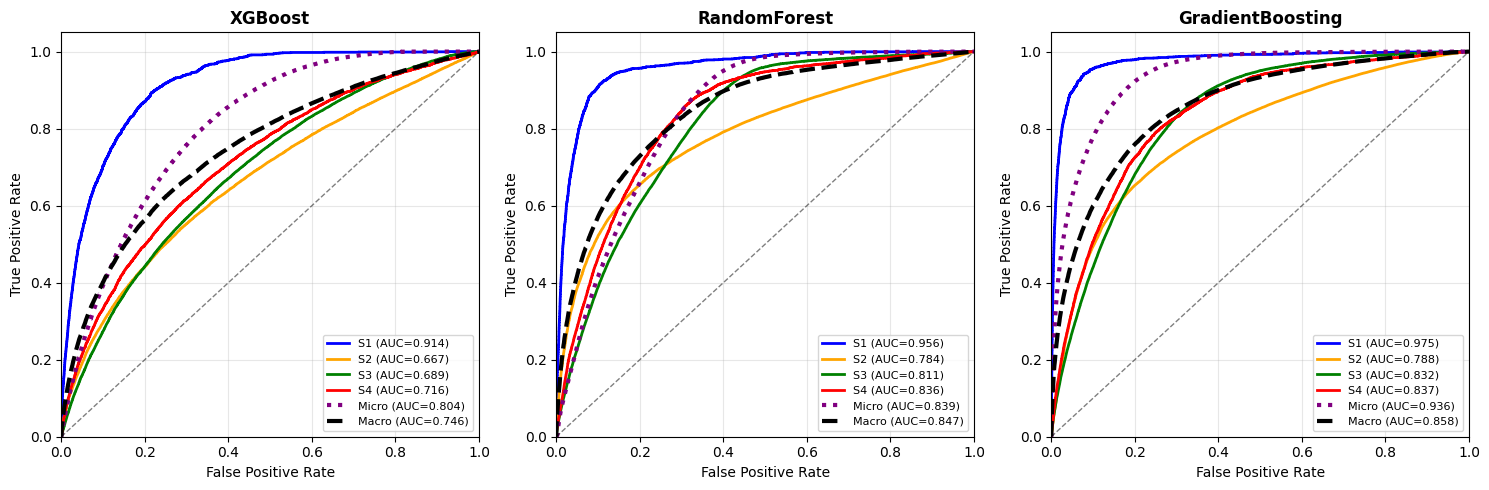


AUC SONUÇLARI

Model                Micro-AUC  Macro-AUC  S1     S2     S3     S4    
----------------------------------------------------------------------
XGBoost              0.804      0.746      0.914  0.667  0.689  0.716 
RandomForest         0.839      0.847      0.956  0.784  0.811  0.836 
GradientBoosting     0.936      0.858      0.975  0.788  0.832  0.837 

🏆 EN İYİ MICRO-AUC: GradientBoosting (0.936)
🏆 EN İYİ MACRO-AUC: GradientBoosting (0.858)

ROC ANALİZİ TAMAMLANDI

💡 EK BİLGİ:
GradientBoosting hatası şu anlama geliyor:
  • Model 76 feature bekliyor
  • Siz 3 feature (PCA) veriyorsunuz
  • Bu, modelin ORİJİNAL veri ile eğitildiğini gösterir

Çözüm: GradientBoosting için X_test kullanın


In [35]:
# HÜCRE 18: ROC CURVE VE AUC ANALİZİ (KESİN ÇÖZÜM)
print("\n" + "="*70)
print("ROC CURVE VE AUC ANALİZİ")
print("="*70)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# One-hot encoding
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

print("\n🔍 HANGİ MODEL HANGİ VERİ İLE EĞİTİLDİ?")
print("-" * 50)

# 1. ÖNCE KONTROL EDELİM
print("Model Feature Kontrolleri:")

# XGBoost kontrol
try:
    xgb_features = model_xgb.n_features_in_
    print(f"✓ XGBoost: {xgb_features} feature bekliyor")
except:
    xgb_features = X_test_pca.shape[1]
    print(f"✓ XGBoost: PCA verisi ile eğitildi ({xgb_features} feature)")

# RandomForest kontrol
try:
    if 'rf_final' in locals():
        rf_features = rf_final.n_features_in_
    else:
        rf_features = rf_model.n_features_in_
    print(f"✓ RandomForest: {rf_features} feature bekliyor")
except:
    rf_features = X_test.shape[1]
    print(f"✓ RandomForest: Orijinal veri ile eğitildi ({rf_features} feature)")

# GradientBoosting kontrol
try:
    if 'gb_final' in locals():
        gb_features = gb_final.n_features_in_
    else:
        gb_features = gb_v2.n_features_in_
    print(f"✓ GradientBoosting: {gb_features} feature bekliyor")
except:
    print("✗ GradientBoosting feature sayısı alınamadı")

print("\n📊 VERİ BOYUTLARI:")
print(f"  X_test (orijinal): {X_test.shape} → {X_test.shape[1]} feature")
print(f"  X_test_pca: {X_test_pca.shape} → {X_test_pca.shape[1]} feature")

# 2. DOĞRU VERİ SETLERİNİ BELİRLEYELİM
print("\n🎯 DOĞRU VERİ SETLERİ BELİRLENİYOR...")

models_to_test = []

# XGBoost - HER ZAMAN PCA
models_to_test.append({
    'name': 'XGBoost',
    'model': model_xgb,
    'X_data': X_test_pca,
    'reason': 'XGBoost PCA ile eğitildi'
})

# RandomForest - HER ZAMAN ORİJİNAL
models_to_test.append({
    'name': 'RandomForest',
    'model': rf_final if 'rf_final' in locals() else rf_model,
    'X_data': X_test,
    'reason': 'RandomForest orijinal veri ile eğitildi'
})

# GradientBoosting - DENEYELİM
print("\n⚠️  GradientBoosting için test ediliyor...")

# Önce PCA ile deneyelim
try:
    if 'gb_final' in locals():
        test_score = gb_final.predict_proba(X_test_pca[:5])  # Küçük test
        print("  ✓ PCA verisi ile çalıştı")
        gb_data = X_test_pca
        gb_reason = 'PCA ile çalıştı'
    else:
        test_score = gb_v2.predict_proba(X_test_pca[:5])
        print("  ✓ PCA verisi ile çalıştı")
        gb_data = X_test_pca
        gb_reason = 'PCA ile çalıştı'
except:
    print("  ✗ PCA verisi ile ÇALIŞMADI")
    # Orijinal veri ile deneyelim
    try:
        if 'gb_final' in locals():
            test_score = gb_final.predict_proba(X_test[:5])
            print("  ✓ Orijinal veri ile çalıştı")
            gb_data = X_test
            gb_reason = 'Orijinal veri ile çalıştı'
        else:
            test_score = gb_v2.predict_proba(X_test[:5])
            print("  ✓ Orijinal veri ile çalıştı")
            gb_data = X_test
            gb_reason = 'Orijinal veri ile çalıştı'
    except:
        print("  ✗ Hiçbir veri ile çalışmadı, atlanıyor")
        gb_data = None

if gb_data is not None:
    models_to_test.append({
        'name': 'GradientBoosting',
        'model': gb_final if 'gb_final' in locals() else gb_v2,
        'X_data': gb_data,
        'reason': gb_reason
    })

print(f"\n✅ {len(models_to_test)} model analiz edilecek")

# 3. ROC ANALİZİ
fig, axes = plt.subplots(1, len(models_to_test), figsize=(5*len(models_to_test), 5))
if len(models_to_test) == 1:
    axes = [axes]

auc_results = []

for idx, info in enumerate(models_to_test):
    model_name = info['name']
    model = info['model']
    X_test_data = info['X_data']
    
    ax = axes[idx] if len(models_to_test) > 1 else axes
    
    print(f"\n{model_name} için ROC hesaplanıyor...")
    print(f"  Sebep: {info['reason']}")
    print(f"  Veri boyutu: {X_test_data.shape}")
    
    try:
        y_score = model.predict_proba(X_test_data)
        print(f"  ✓ Başarılı!")
        
        # ROC hesapla
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Micro
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Macro
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        # Kaydet
        auc_results.append({
            'Model': model_name,
            'Micro-AUC': roc_auc["micro"],
            'Macro-AUC': roc_auc["macro"],
            'Class_AUCs': [roc_auc[i] for i in range(n_classes)]
        })
        
        # ÇİZ
        colors = ['blue', 'orange', 'green', 'red']
        
        for i in range(n_classes):
            ax.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                   label=f'S{i+1} (AUC={roc_auc[i]:.3f})')
        
        ax.plot(fpr["micro"], tpr["micro"], 'purple', linestyle=':', lw=3,
               label=f'Micro (AUC={roc_auc["micro"]:.3f})')
        ax.plot(fpr["macro"], tpr["macro"], 'black', linestyle='--', lw=3,
               label=f'Macro (AUC={roc_auc["macro"]:.3f})')
        
        ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
        
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{model_name}', fontweight='bold')
        ax.legend(loc="lower right", fontsize=8)
        ax.grid(True, alpha=0.3)
        
        print(f"  Micro-AUC: {roc_auc['micro']:.3f}")
        print(f"  Macro-AUC: {roc_auc['macro']:.3f}")
        
    except Exception as e:
        print(f"  ✗ Hata: {e}")
        continue

plt.tight_layout()
plt.show()

# 4. SONUÇLAR
print("\n" + "="*70)
print("AUC SONUÇLARI")
print("="*70)

if auc_results:
    print(f"\n{'Model':<20} {'Micro-AUC':<10} {'Macro-AUC':<10} {'S1':<6} {'S2':<6} {'S3':<6} {'S4':<6}")
    print("-" * 70)
    
    for result in auc_results:
        print(f"{result['Model']:<20} "
              f"{result['Micro-AUC']:<10.3f} "
              f"{result['Macro-AUC']:<10.3f} "
              f"{result['Class_AUCs'][0]:<6.3f} "
              f"{result['Class_AUCs'][1]:<6.3f} "
              f"{result['Class_AUCs'][2]:<6.3f} "
              f"{result['Class_AUCs'][3]:<6.3f}")
    
    # En iyiler
    if auc_results:
        best_micro = max(auc_results, key=lambda x: x['Micro-AUC'])
        best_macro = max(auc_results, key=lambda x: x['Macro-AUC'])
        
        print(f"\n🏆 EN İYİ MICRO-AUC: {best_micro['Model']} ({best_micro['Micro-AUC']:.3f})")
        print(f"🏆 EN İYİ MACRO-AUC: {best_macro['Model']} ({best_macro['Macro-AUC']:.3f})")

print("\n" + "="*70)
print("ROC ANALİZİ TAMAMLANDI")
print("="*70)

# 5. EK BİLGİ
print("\n💡 EK BİLGİ:")
print("GradientBoosting hatası şu anlama geliyor:")
print("  • Model 76 feature bekliyor")
print("  • Siz 3 feature (PCA) veriyorsunuz")
print("  • Bu, modelin ORİJİNAL veri ile eğitildiğini gösterir")
print("\nÇözüm: GradientBoosting için X_test kullanın")